### Import Required Libraries
### We start by importing necessary Python libraries for data processing, visualization, and clustering.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

### Load Dataset from R's AdhereR Package
### We use the `AdhereR` package in R to load the `med.events` dataset into Python.

In [ ]:
pandas2ri.activate()
robjects.r('library(AdhereR)')
med_events_r = robjects.r('med.events')
med_events = pandas2ri.rpy2py(med_events_r)

### Make a copy of the dataset

In [ ]:
ExamplePats = med_events.copy()
tidy = ExamplePats.copy()

### Rename columns for clarity

In [ ]:
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]

### Convert `eksd` column to datetime format

In [ ]:
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format='%m/%d/%Y')

### Define the `See()` Function
### This function analyzes prescription refill intervals, performs clustering, and visualizes results.

In [ ]:
def See(arg1):
    # Filter data for a specific drug (ATC code)
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()
    
    # Process prescription refill intervals
    Drug_see_p1 = C09CA01.sort_values(by=['pnr', 'eksd'])
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])
    
    # Randomly sample one row per patient
    Drug_see_p1 = Drug_see_p1.groupby('pnr', group_keys=False).apply(lambda x: x.sample(n=1, random_state=1234))
    Drug_see_p1['event.interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days.astype(float)
    
    # Compute the Empirical Cumulative Distribution Function (ECDF)
    ecdf_func = ECDF(Drug_see_p1['event.interval'])
    x_vals = ecdf_func.x
    y_vals = ecdf_func.y
    dfper = pd.DataFrame({'x': x_vals, 'y': y_vals})
    
    # Filter the lower 80% of ECDF
    dfper = dfper[dfper['y'] <= 0.8]
    dfper = dfper[np.isfinite(dfper['x'])]
    max_x = dfper['x'].max()
    
    # Visualize ECDF (80% vs 100%)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(dfper['x'], dfper['y'])
    axs[0].set_title("80% ECDF")
    axs[1].plot(x_vals, y_vals)
    axs[1].set_title("100% ECDF")
    plt.show()
    
    # Frequency plot of patient counts
    Drug_see_p1['pnr'].value_counts().plot(kind='bar', title="Frequency of pnr")
    plt.show()
    
    # Log-transformed density plot
    log_event = np.log(Drug_see_p1['event.interval'])
    density = gaussian_kde(log_event)
    x1 = np.linspace(log_event.min(), log_event.max(), 100)
    y1 = density(x1)
    plt.plot(x1, y1)
    plt.title("Log(event interval)")
    plt.show()
    
    # Scale data for clustering
    a_df = pd.DataFrame({'x': x1, 'y': y1})
    scaler = StandardScaler()
    a_scaled = scaler.fit_transform(a_df)
    
    # Determine optimal `eps` for DBSCAN
    best_eps = None
    best_score = -1
    scores = {}
    eps_values = np.linspace(0.1, 2.0, 20)
    
    for eps in eps_values:
        db = DBSCAN(eps=eps, min_samples=5).fit(a_scaled)
        if len(set(db.labels_)) > 1:
            score = silhouette_score(a_scaled, db.labels_)
            scores[eps] = score
            if score > best_score:
                best_score = score
                best_eps = eps
    
    plt.plot(list(scores.keys()), list(scores.values()), marker='o')
    plt.title("DBSCAN Silhouette Analysis")
    plt.xlabel("Epsilon (eps)")
    plt.ylabel("Silhouette Score")
    plt.show()
    
    # DBSCAN clustering
    db = DBSCAN(eps=best_eps, min_samples=5)
    dfper['cluster'] = db.fit_predict(dfper[['x']])
    dfper = dfper[dfper['cluster'] != -1]
    
    # Cluster statistics
    cluster_stats = dfper.groupby('cluster')['x'].agg(['min', 'max', 'median']).reset_index()
    cluster_stats.columns = ['Cluster', 'Minimum', 'Maximum', 'Median']
    
    # Merge results
    results = Drug_see_p1.merge(cluster_stats, how='cross')
    results['Final_cluster'] = np.where(
        (results['event.interval'] >= results['Minimum']) & (results['event.interval'] <= results['Maximum']),
        results['Cluster'], np.nan)
    results = results.dropna()[['pnr', 'Median', 'Cluster']]
    
    # Assign clusters back to dataset
    Drug_see_p0 = pd.merge(C09CA01, results, on='pnr', how='left')
    Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(cluster_stats['Median'].min())
    Drug_see_p0['Cluster'] = Drug_see_p0['Cluster'].fillna(0)
    
    return Drug_see_p0

### Define `see_assumption()` Function
### This function checks assumptions about prescription intervals.

In [ ]:
def see_assumption(arg1):
    arg1 = arg1.sort_values(by=['pnr', 'eksd'])
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)
    arg1['p_number'] = arg1.groupby('pnr').cumcount() + 1
    
    Drug_see2 = arg1[arg1['p_number'] >= 2].copy()
    Drug_see2['Duration'] = (Drug_see2['eksd'] - Drug_see2['prev_eksd']).dt.days.astype(float)
    global_median = Drug_see2['Duration'].median()
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='p_number', y='Duration', data=Drug_see2)
    plt.axhline(global_median, linestyle='dashed', color='red')
    plt.yticks(np.arange(0, 350, 100))
    plt.xlabel("p_number")
    plt.ylabel("Duration")
    plt.title("Boxplot of Duration by p_number")
    plt.show()
    
    return plt

### Sessa Empirical Estimator using DBSCAN
This script is analyzing medication adherence data using clustering techniques. It imports data from R's AdhereR package, processes it using pandas, and applies density estimation and clustering using DBSCAN. It also visualizes empirical cumulative distribution functions (ECDFs), frequency distributions, and clustering results

### Filtering Medication Data
In the See() function, it extracts only the prescription for a specific medication, which in this case is arg1. We sort the prescription by patient (pnr) and date (eksd), then we compute the previous prescription date per patient. Each patient may have multiple prescriptions over time. Sorting ensures that we analyze prescriptions in the correct chronological order. It allows us to track when each patient received their previous prescription. This helps in calculating the time gap between consecutive prescriptions (event interval).

### Empirical Cumulative Distribution Function (ECDF)
ECDF (Empirical CDF) estimates the probability distribution of event.interval. Outliers above the 80th percentile are removed to focus on typical prescription behaviors.

### Clustering with DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is used in this section to cluster event intervals derived from the prescription data. The goal is to identify different patterns in the time gaps between prescriptions.

In [ ]:
scaler = StandardScaler()
a_scaled = scaler.fit_transform(pd.DataFrame({'x': x1, 'y': y1}))

DBSCAN is sensitive to scale differences. If one feature has much larger values than another, the clustering can be biased. StandardScaler() transforms the data so that it has:
- Mean = 0
- Standard deviation = 1

### Finding the Optimal eps (Neighborhood Radius)

In [ ]:
best_eps = None
best_score = -1
scores = {}

eps_values = np.linspace(0.1, 2.0, 20)  # Try different epsilon values
for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5).fit(a_scaled)
    if len(set(db.labels_)) > 1:  # Must have at least 2 clusters
        score = silhouette_score(a_scaled, db.labels_)
        scores[eps] = score
        if score > best_score:
            best_score = score
            best_eps = eps

eps defines the maximum distance between two points to be considered neighbors. The correct eps is not known beforehand, so we iterate over a range of values (0.1 to 2.0). 
For each eps:
- Apply DBSCAN with that eps.
- Check if at least 2 clusters exist (if all points are in one cluster, the silhouette score is meaningless).
- Compute silhouette score (measures how well-separated the clusters are).
- Store the best eps with the highest silhouette score.

After that, we fit DBSCAN to dfper[['x']], which contains the event interval values from the ECDF, remove noise points, and computing cluster statistics.

Key Differences & Inference
| Aspect | K-Means	| DBSCAN |
| -------|----------|--------|
| Cluster Shape |	Assumes clusters are spherical |	Detects arbitrarily shaped clusters |
| Number of Clusters (k) |	Must be pre-defined |	No need to specify (determined by eps) |
| Noise Handling |	No built-in noise detection |	Identifies noise points (-1) |
| Density Consideration |	Doesn't consider density |	Clusters based on density |
| Silhouette Analysis |	Directly compares within-cluster vs. between-cluster distances |	Requires eps tuning to maximize score |

When comparing K-Means and DBSCAN, we observed that the key difference in the results was in the silhouette analysis. This is because DBSCAN uses eps (epsilon) for defining clusters, whereas K-Means relies on centroids and a fixed number of clusters (k).

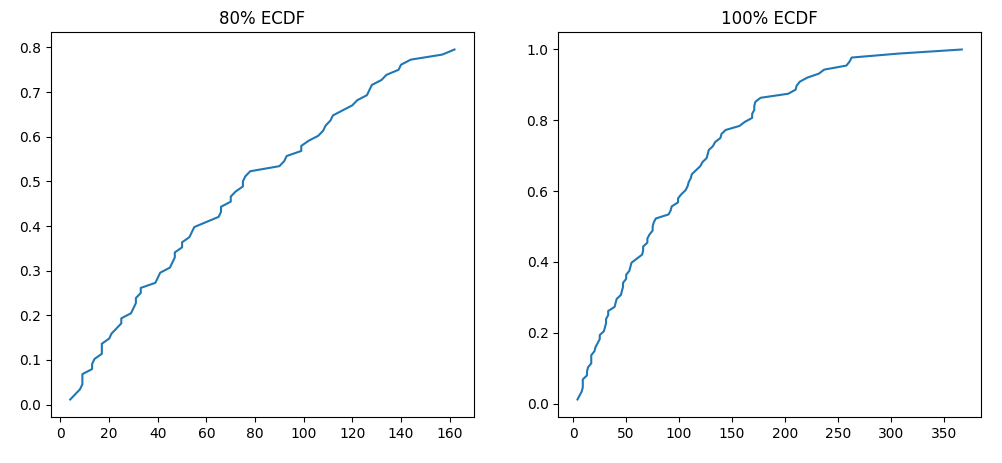

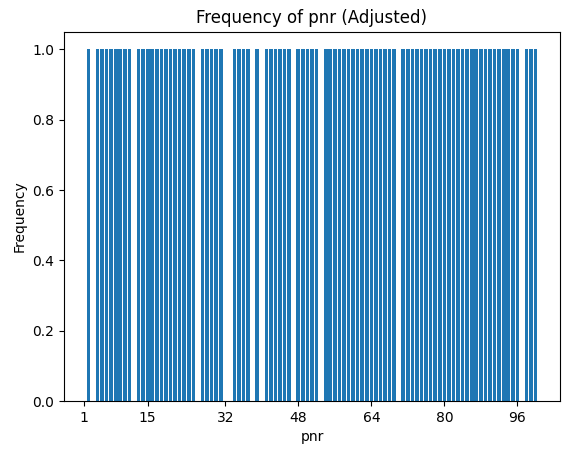
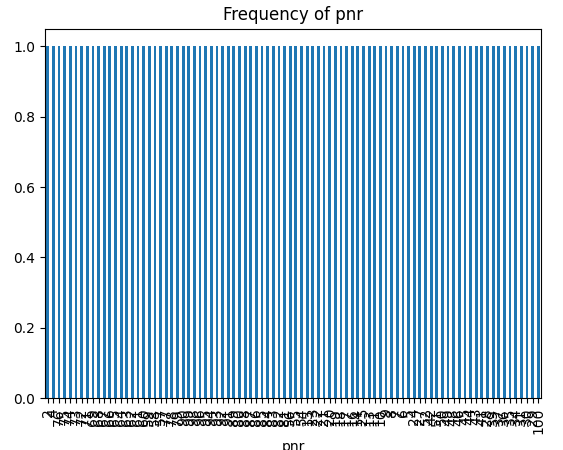

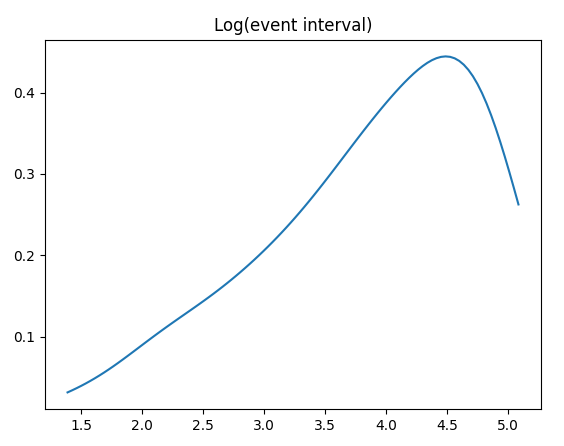

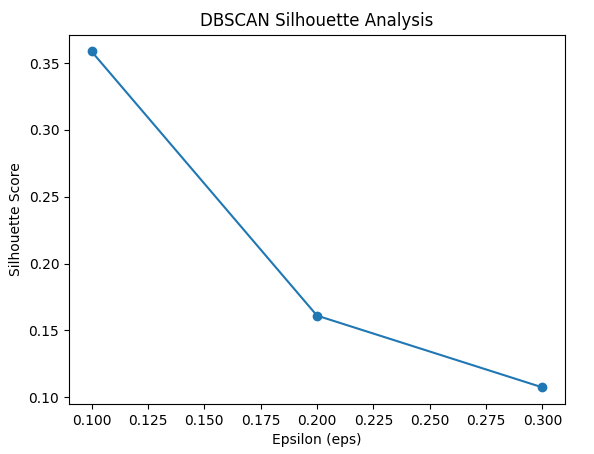

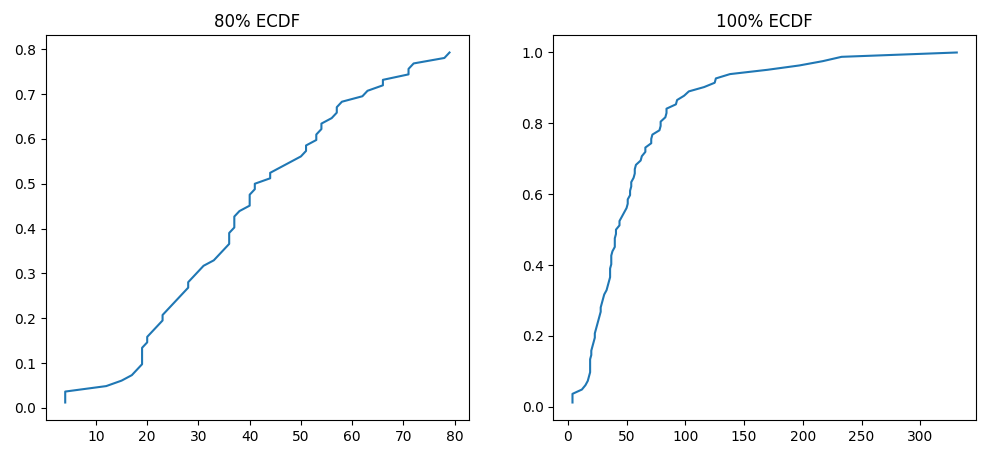

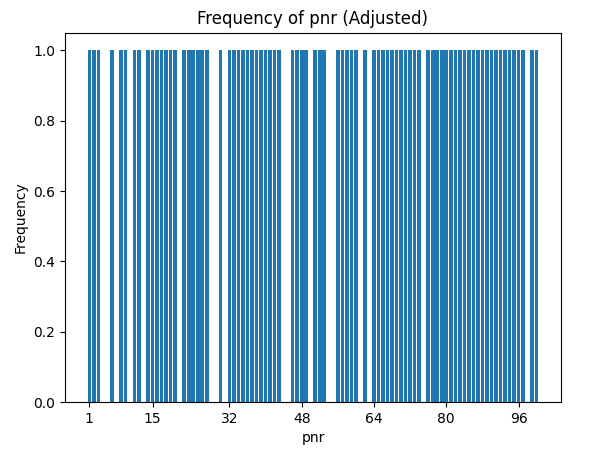
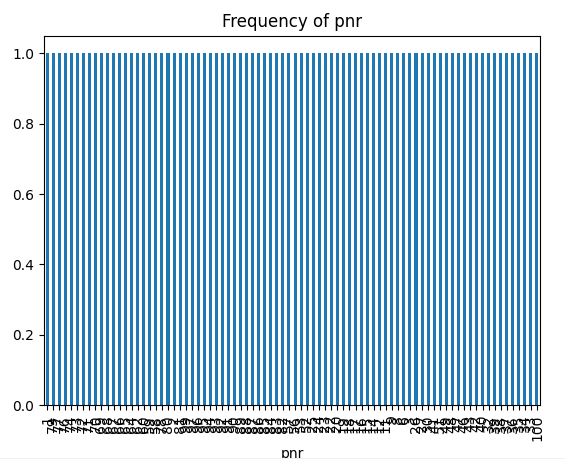

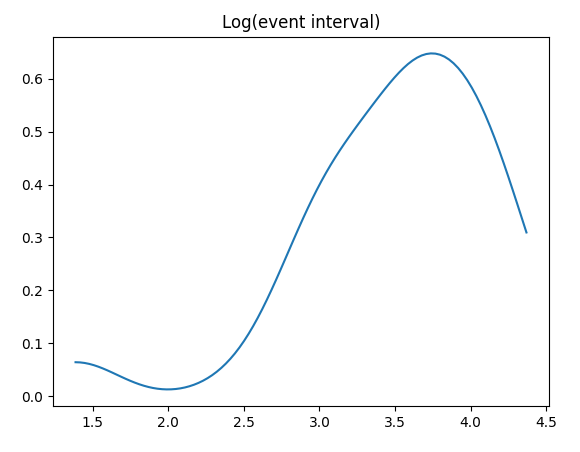

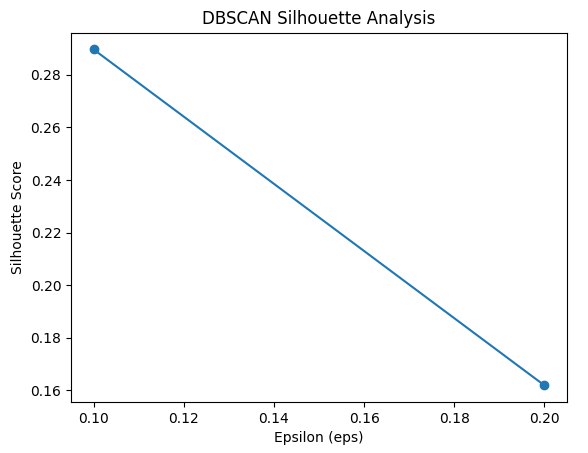

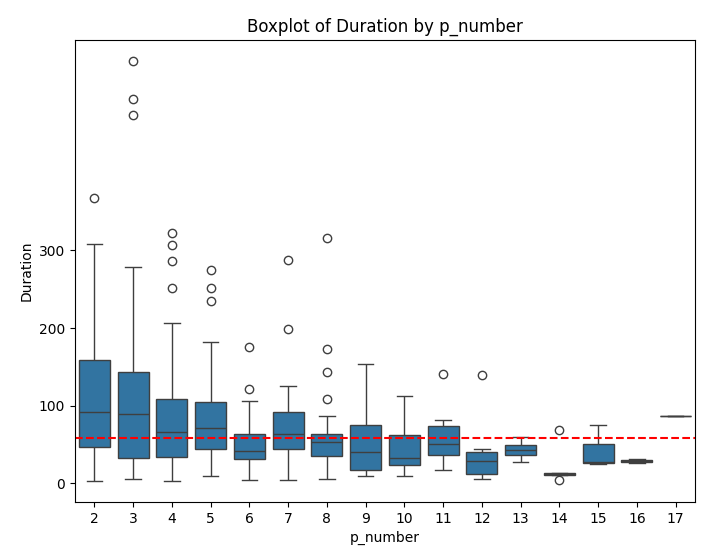

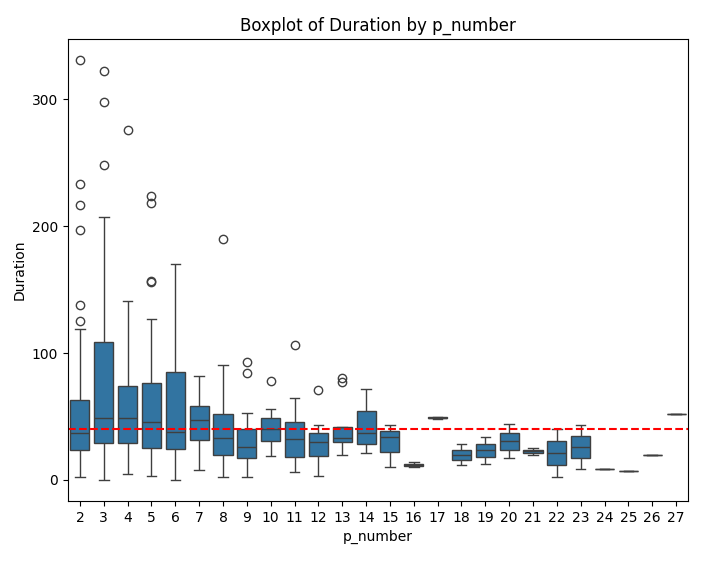